In [1]:
from surprise.model_selection import cross_validate, GridSearchCV
from surprise.prediction_algorithms import SVD, KNNBasic, KNNBaseline
from surprise import Dataset
from surprise import Reader
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

1. Number of children's movies: 664


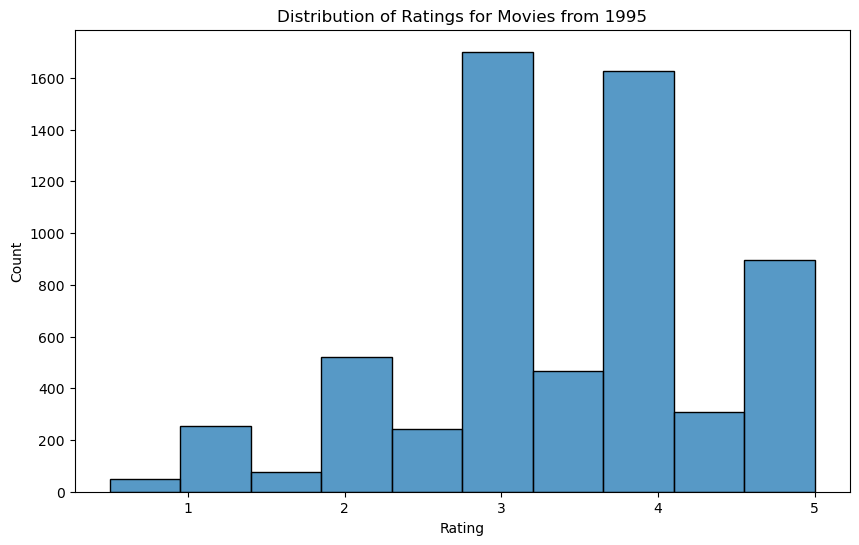

2. Number of ratings for 1995 movies: 6143
3. Average rating for all action movies: 3.09
Top 3 highest rated action movies:
  1. Fight Club (1999) - 4.27 (based on 218 ratings)
  2. Dark Knight, The (2008) - 4.24 (based on 149 ratings)
  3. Princess Bride, The (1987) - 4.23 (based on 142 ratings)


In [ ]:
movies = pd.read_csv("data/ml-latest-small/movies.csv")
ratings = pd.read_csv("data/ml-latest-small/ratings.csv")
tags = pd.read_csv("data/ml-latest-small/tags.csv")


children_movies = movies[movies["genres"].str.contains("Children", na=False)]
print(f"1. Number of children's movies: {len(children_movies)}")


movies["year"] = movies["title"].str.extract(r"\((\d{4})\)$")
movies_1995 = movies[movies["year"] == "1995"]
movies_1995_ids = movies_1995["movieId"].values

ratings_1995 = ratings[ratings["movieId"].isin(movies_1995_ids)]

plt.figure(figsize=(10, 6))
sns.histplot(data=ratings_1995, x="rating", bins=10)
plt.title("Distribution of Ratings for Movies from 1995")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

print(f"2. Number of ratings for 1995 movies: {len(ratings_1995)}")

# 3. Average rating for action movies and top 3 highest rated
action_movies = movies[movies["genres"].str.contains("Action", na=False)]
action_ratings = ratings[ratings["movieId"].isin(action_movies["movieId"])]

# Calculate average rating per movie
action_avg_ratings = action_ratings.groupby("movieId")["rating"].mean().reset_index()
action_avg_ratings = action_avg_ratings.merge(movies[["movieId", "title"]], on="movieId")

# Overall average for action movies
action_overall_avg = action_avg_ratings["rating"].mean()

# TODO change to bayessian average


# Top 3 highest rated action movies (with minimum 100 ratings for reliability)
rating_counts = action_ratings.groupby("movieId")["rating"].count().reset_index(name="count")
action_avg_with_counts = action_avg_ratings.merge(rating_counts, on="movieId")
top_action_movies = (
    action_avg_with_counts[action_avg_with_counts["count"] >= 100].sort_values("rating", ascending=False).head(3)
)

print(f"3. Average rating for all action movies: {action_overall_avg:.2f}")
print("Top 3 highest rated action movies:")
for i, (_, row) in enumerate(top_action_movies.iterrows(), 1):
    print(f"  {i}. {row['title']} - {row['rating']:.2f} (based on {row['count']} ratings)")

In [ ]:
import random

# Prepare data for Surprise library
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[["userId", "movieId", "rating"]], reader)

# Build and evaluate SVD model
print("Training SVD model...")
svd = SVD()
svd_results = cross_validate(svd, data, measures=["RMSE", "MAE"], cv=5, verbose=True)

print(f"SVD Mean RMSE: {np.mean(svd_results['test_rmse']):.4f}")
print(f"SVD Mean MAE: {np.mean(svd_results['test_mae']):.4f}")

# Parameter tuning for SVD
print("\nPerforming parameter tuning for SVD...")
param_grid_svd = {"n_epochs": [10, 20, 30], "lr_all": [0.002, 0.005, 0.01], "reg_all": [0.2, 0.4, 0.6]}

gs_svd = GridSearchCV(SVD, param_grid_svd, measures=["rmse"], cv=3)
gs_svd.fit(data)

print(f"Best SVD RMSE: {gs_svd.best_score['rmse']:.4f}")
print(f"Best SVD parameters: {gs_svd.best_params['rmse']}")

Training SVD model...
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8741  0.8738  0.8805  0.8706  0.8666  0.8731  0.0046  
MAE (testset)     0.6698  0.6709  0.6750  0.6696  0.6650  0.6701  0.0032  
Fit time          0.96    0.86    0.86    0.87    0.89    0.89    0.04    
Test time         0.10    0.09    0.08    0.09    0.09    0.09    0.00    
SVD Mean RMSE: 0.8731
SVD Mean MAE: 0.6701

Performing parameter tuning for SVD...
Best SVD RMSE: 0.8735
Best SVD parameters: {'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


In [8]:
# Build and tune KNN model (randomly selected KNNWithMeans)
print("\nTraining KNN model...")
knn = KNNBaseline(sim_options={"user_based": False})  # Item-based collaborative filtering
knn_results = cross_validate(knn, data, measures=["RMSE", "MAE"], cv=3, verbose=True)

print(f"KNN Mean RMSE: {np.mean(knn_results['test_rmse']):.4f}")
print(f"KNN Mean MAE: {np.mean(knn_results['test_mae']):.4f}")

# Parameter tuning for KNN with randomly selected k values
k_values = [
    3,
    5,
    8,
    11,
]  # Randomly select 5 k values between 5 and 100
print(f"Testing k values: {k_values}")

param_grid_knn = {
    "k": k_values,
    "sim_options": {"name": ["msd", "cosine", "pearson"], "user_based": [False]},  # Item-based CF
}

gs_knn = GridSearchCV(KNNBaseline, param_grid_knn, measures=["rmse"], cv=3)
gs_knn.fit(data)

print(f"Best KNN RMSE: {gs_knn.best_score['rmse']:.4f}")
print(f"Best KNN parameters: {gs_knn.best_params['rmse']}")


Training KNN model...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8693  0.8683  0.8727  0.8701  0.0019  
MAE (testset)     0.6673  0.6650  0.6698  0.6674  0.0019  
Fit time          2.75    2.74    2.44    2.64    0.15    
Test time         8.48    8.33    6.84    7.88    0.74    
KNN Mean RMSE: 0.8701
KNN Mean MAE: 0.6674
Testing k values: [3, 5, 8, 11]
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using a

In [ ]:
best_svd = gs_svd.best_estimator["rmse"]
best_knn = gs_knn.best_estimator["rmse"]
trainset = data.build_full_trainset()
best_svd.fit(trainset)
best_knn.fit(trainset)

# Generate recommendations for a sample user

# Compare performance of both algorithms
print("\nPerformance comparison:")
print(f"SVD: RMSE = {gs_svd.best_score['rmse']:.4f}")
print(f"KNN: RMSE = {gs_knn.best_score['rmse']:.4f}")
print(f"Winner: {'SVD' if gs_svd.best_score['rmse'] < gs_knn.best_score['rmse'] else 'KNN'}")

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.

Performance comparison:
SVD: RMSE = 0.8735
KNN: RMSE = 0.8967
Winner: SVD


In [ ]:
# Get recommendations for movie_id = 1 (Toy Story) using the KNN model
movie_id = 1
movie_title = movies[movies["movieId"] == movie_id]["title"].iloc[0]

# We need to access the model's inner_item_id for the movie
movie_inner_id = best_knn.trainset.to_inner_iid(movie_id)

# Get the nearest neighbors
k = best_knn.k  # Use the optimal k found during grid search
neighbors = best_knn.get_neighbors(movie_inner_id, k=k)

# Convert inner ids back to raw ids and get the movie information
neighbor_ids = [best_knn.trainset.to_raw_iid(inner_id) for inner_id in neighbors]
neighbor_movies = movies[movies["movieId"].isin(neighbor_ids)]

# Get ratings information for the neighbors
neighbor_ratings = []
for id in neighbor_ids:
    # Get the average rating for this movie
    avg_rating = ratings[ratings["movieId"] == id]["rating"].mean()
    # Get number of ratings
    num_ratings = ratings[ratings["movieId"] == id].shape[0]
    neighbor_ratings.append((id, avg_rating, num_ratings))

# Create a DataFrame with the recommendations
recommendations_df = pd.DataFrame(neighbor_ratings, columns=["movieId", "avg_rating", "num_ratings"])
recommendations_df = recommendations_df.merge(neighbor_movies[["movieId", "title", "genres"]], on="movieId")

# Sort by average rating
recommendations_df = recommendations_df.sort_values("avg_rating", ascending=False)

# Print the results
print(f"Top {k} movies similar to '{movie_title}' based on KNN algorithm:")
for i, row in recommendations_df.iterrows():
    print(f"{i+1}. {row['title']} - Rating: {row['avg_rating']:.2f} ({row['num_ratings']} ratings) predicted rating ")
    print(f"   Genres: {row['genres']}")

Top 11 movies similar to 'Toy Story (1995)' based on KNN algorithm:
2. Hangar 18 (1980) - Rating: 4.50 (2 ratings)
   Genres: Action|Sci-Fi|Thriller
5. Afterglow (1997) - Rating: 4.50 (4 ratings)
   Genres: Drama|Romance
7. L.I.E. (2001) - Rating: 4.33 (3 ratings)
   Genres: Drama
1. Best Men (1997) - Rating: 4.00 (1 ratings)
   Genres: Action|Comedy|Crime|Drama
6. Divided We Fall (Musíme si pomáhat) (2000) - Rating: 3.83 (3 ratings)
   Genres: Comedy|Drama
11. Tangled Ever After (2012) - Rating: 3.83 (3 ratings)
   Genres: Action|Animation|Children
3. Death Race 2000 (1975) - Rating: 3.67 (3 ratings)
   Genres: Action|Sci-Fi
9. Roommates (1995) - Rating: 3.67 (3 ratings)
   Genres: Comedy|Drama
4. Maya Lin: A Strong Clear Vision (1994) - Rating: 3.50 (2 ratings)
   Genres: Documentary
8. Queen Margot (Reine Margot, La) (1994) - Rating: 3.20 (5 ratings)
   Genres: Drama|Romance
10. Made of Honor (2008) - Rating: 2.88 (4 ratings)
   Genres: Comedy|Romance


In [11]:
sample_user_id = 600
user_seen_movies = set(ratings[ratings["userId"] == sample_user_id]["movieId"])
unseen_movies = [movie_id for movie_id in movies["movieId"] if movie_id not in user_seen_movies]

# Get predictions for unseen movies using both models
svd_predictions = [best_svd.predict(sample_user_id, movie_id) for movie_id in unseen_movies[:100]]
knn_predictions = [best_knn.predict(sample_user_id, movie_id) for movie_id in unseen_movies[:100]]

svd_predictions.sort(key=lambda x: x.est, reverse=True)
knn_predictions.sort(key=lambda x: x.est, reverse=True)

# Show top 5 recommendations from each algorithm
print(f"\nTop 3 SVD recommendations for user {sample_user_id}:")
for i, pred in enumerate(svd_predictions[:3]):
    movie_info = movies[movies["movieId"] == pred.iid].iloc[0]
    print(f"{i+1}. {movie_info['title']} - Predicted rating: {pred.est:.2f}")

print(f"\nTop 3 KNN recommendations for user {sample_user_id}:")
for i, pred in enumerate(knn_predictions[:3]):
    movie_info = movies[movies["movieId"] == pred.iid].iloc[0]
    print(f"{i+1}. {movie_info['title']} - Predicted rating: {pred.est:.2f}")


Top 3 SVD recommendations for user 600:
1. Lamerica (1994) - Predicted rating: 3.64
2. Usual Suspects, The (1995) - Predicted rating: 3.63
3. Heidi Fleiss: Hollywood Madam (1995) - Predicted rating: 3.63

Top 3 KNN recommendations for user 600:
1. Usual Suspects, The (1995) - Predicted rating: 4.31
2. Taxi Driver (1976) - Predicted rating: 4.29
3. Casino (1995) - Predicted rating: 3.75
